In [2]:
from __future__ import print_function, division
import numpy as np
import scipy as sp
from numba import jit, guvectorize

# plotting packages
%matplotlib inline
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("whitegrid")

/home/dmeliza/.virtualenvs/dstrf/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [11]:
# model parameters: (α1, α2, ω, τ1, τ2, tref)
matparams = np.asarray([100, 2, 7, 10, 200, 2], dtype='d')
model_dt = 0.5

# data parameters
duration = 20000
n_samples = int(duration / model_dt)
n_assim = 3
n_test = 0

# assimilation parameters
nthreads = 8
nwalkers = 2000
nsteps = 500
matparams_i = [0,1,2]
matparams_n = len(matparams_i)
matparams_f = matparams[matparams_i]

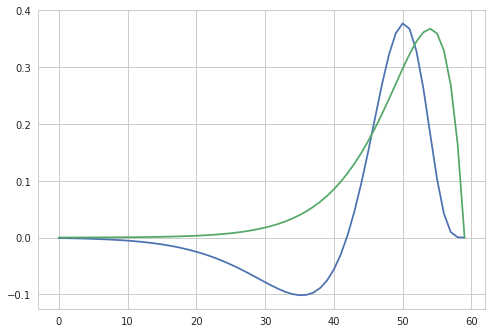

In [5]:
# convolution - simple alpha kernel
from scipy.signal import resample
stim_dt = 10.0
upsample = int(stim_dt / model_dt)

# alpha filter
tau_h = 50
tt = np.arange(0, 600, stim_dt)
ka = np.flipud(tt / tau_h * np.exp(-tt / tau_h))

# difference of gammas:
from scipy.special import gamma
tau_h1 = 600. / 32
tau_h2 = 600. / 16
kg1 = 1/(gamma(6)*tau_h1)*(tt/tau_h1)**5 * np.exp(-tt/tau_h1)
kg2 = 1/(gamma(6)*tau_h2)*(tt/tau_h2)**5 * np.exp(-tt/tau_h2)
kg = np.flipud(kg1 - kg2 / 1.5)
kg /= np.linalg.norm(kg)

plt.plot(kg)
plt.plot(ka)

# select a filter
k1 = (ka * 10)[::-1]

def filter_stimulus(S, k1, upsample=None):
    X = np.convolve(S, k1, mode="same")
    if upsample is not None:
        t = np.arange(X.size)
        tu = np.arange(0, X.size, 1 / upsample)
        return np.interp(tu, t, X)
    else:
        return X
    

In [6]:
# generate data to fit
np.random.seed(1)
#matmodel.random_seed(1)
data = []
stim = np.random.randn(int(n_samples / (stim_dt / model_dt)))
stim[:100] = 0

@jit
def predict_spikes(V, params, dt, upsample):
    N = V.size * upsample
    S = np.zeros(N, dtype='i')
    P = np.zeros(N, dtype='d')
    R = np.random.uniform(size=N)
    omega = params[2]
    A1 = np.exp(-dt / params[3])
    A2 = np.exp(-dt / params[4])
    i_refrac = int(params[5] / dt)
    H1 = H2 = 0
    iref = 0
    for i in range(N):
        Vt = V[i // upsample]
        H1 *= A1
        H2 *= A2
        p = np.exp(Vt - H1 - H2 - omega) * dt
        if i > iref and p > R[i]:
            H1 += params[0]
            H2 += params[1]
            iref = i + i_refrac
            S[i] = 1
    return S


@jit
def lci_poisson(V, params, spikes, dt, upsample):
    N = V.size * upsample
    lp = 0
    omega = params[2]
    A1 = np.exp(-dt / params[3])
    A2 = np.exp(-dt / params[4])
    H1 = H2 = 0
    for i in range(N):
        Vt = V[i // upsample]
        H1 *= A1
        H2 *= A2
        mu = Vt - H1 - H2 - omega
        lp += spikes[i] * mu - dt * np.exp(mu)
        if not np.isfinite(lp):
            return np.inf
        if spikes[i]:
            H1 += params[0]
            H2 += params[1]
    return lp

        
V = filter_stimulus(stim, k1, upsample)
for i in range(n_assim + n_test):
    spikes = predict_spikes(V, matparams, model_dt, upsample=1)
    lp = lci_poisson(V, matparams, spikes, model_dt, upsample=1)
    z = np.nonzero(spikes)[0]
    d = {"V": V,
         "duration": duration,
         "spike_t": z, 
         "spike_v": spikes,
         "lci": lp
         }
    data.append(d)

# split into assimilation and test sets
assim_data = data[:n_assim]
test_data = data[n_assim:]

179

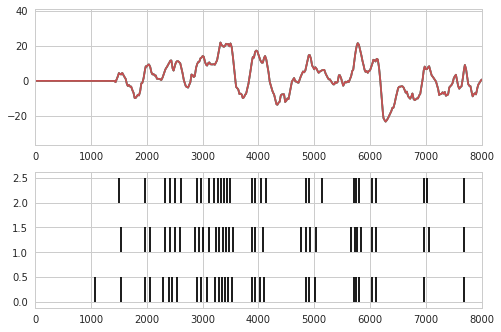

In [7]:
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
for i, d in enumerate(data):
    ax1.plot(data[0]["V"])
    ax2.vlines(d["spike_t"], i, i + 0.5)
ax1.set_xlim(0, 8000)
ax2.set_xlim(0, 8000)
sum(d["lci"] for d in data)
len(data[0]["spike_t"])

In [8]:
# estimate parameters using emcee
from neurofit import priors, costs, utils, startpos
import emcee

mat_prior = priors.joint_independent(
                [ priors.uniform(-50,  200),
                  priors.uniform(-5,   10),
                  priors.uniform( 0,  20),
                ])
startparams = np.asarray([[-50, 200],
                          [-5, 10],
                          [0, 20],
                         ], dtype='d')

# lasso prior on RF parameters
rf_lambda = 1.0

# this is the local copy of the parameters that we'll update in each step
mparams = matparams.copy()
rfparams = k1.copy()

def lnpost_dyn(theta):
    """Posterior probability for dynamical parameters"""
    from mat_neuron._model import predict_adaptation
    mparams[matparams_i] = theta[:matparams_n]
    rfparams[:] = theta[matparams_n:]
    rf_prior = -np.sum(np.abs(theta)) * rf_lambda
    ll = mat_prior(theta[:matparams_n]) + rf_prior
    if not np.isfinite(ll):
        return -np.inf
    lp = 0
    V = filter_stimulus(stim, rfparams, upsample)
    for d in assim_data:
        #H = predict_adaptation(matstate, mparams, d["spike_v"], model_dt)
        lp += lci_poisson(V, mparams, d["spike_v"], model_dt, upsample=1)
    return ll + lp        

In [9]:
# theoretically this is as good as it can get
theta_true = np.concatenate([matparams_f, k1])
print("lnpost of p_true: {}".format(lnpost_dyn(theta_true)))
# and this is our initial state
p0 = np.concatenate([startpos.uniform_independent(nwalkers, startparams[:,0], startparams[:,1]),
                     startpos.normal_independent(nwalkers, k1, [0.1] * k1.size)],
                   axis=1)
theta_0 = np.median(p0, 0)
print("lnpost of p0 median: {}".format(lnpost_dyn(theta_0)))
%timeit lnpost_dyn(theta_true)
%time for theta_0 in p0: lnpost_dyn(theta_0)

lnpost of p_true: -1629.57869945
lnpost of p0 median: -3368.45987983
100 loops, best of 3: 4.43 ms per loop
CPU times: user 8.89 s, sys: 0 ns, total: 8.89 s
Wall time: 8.89 s


In [12]:
sampler = emcee.EnsembleSampler(nwalkers, matparams_f.size, lnpost_dyn, threads=nthreads)
tracker = utils.convergence_tracker(nsteps, 25)

for pos, prob, _ in tracker(sampler.sample(p0, iterations=nsteps, storechain=False)): 
    continue

  step      lnprob        time         ETA
------------------------------------------
    25     -2324.8     0:00:34     0:11:30
    50     -1752.5     0:01:13     0:11:14
    75     -1652.1     0:01:51     0:10:39
   100     -1631.7     0:02:29     0:10:04
   125       -1625     0:03:07     0:09:29
   150     -1621.3     0:03:46     0:08:52
   175     -1618.5     0:04:23     0:08:14
   200     -1616.4     0:05:02     0:07:37
   225     -1614.4     0:05:43     0:07:02
   250     -1612.9     0:06:22     0:06:25
   275     -1611.7     0:07:00     0:05:46
   300     -1610.6     0:07:42     0:05:10
   325     -1609.7     0:08:26     0:04:35
   350     -1608.9     0:09:11     0:03:58
   375     -1608.3     0:09:56     0:03:20
   400     -1607.7     0:10:40     0:02:42
   425       -1607     0:11:25     0:02:02
   450     -1606.5     0:12:10     0:01:22
   475       -1606     0:12:55     0:00:42
   500     -1605.5     0:13:40     0:00:01
   501     -1605.5     0:13:42     0:00:00


lnpost of p median: -1605.45222598
average acceptance fraction: 0.550896
[ 100.    2.    7.]
[ 96.11757195   2.01885505   6.86272225]


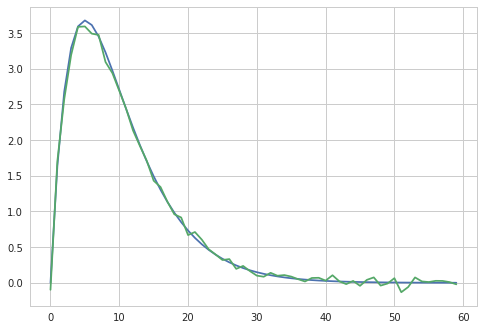

In [13]:
print("lnpost of p median: {}".format(np.median(prob)))
print("average acceptance fraction: {}".format(sampler.acceptance_fraction.mean()))
theta = np.median(pos, 0)
mparams[matparams_i] = theta[:matparams_n]
rfparams[:] = theta[matparams_n:]
plt.plot(k1)
plt.plot(rfparams)
print(matparams_f)
print(theta[:matparams_n])

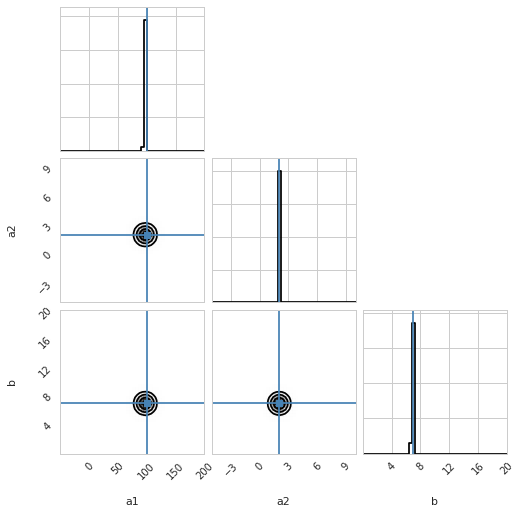

In [14]:
from corner import corner
sns.set_style("whitegrid")

mpos = pos[:,:matparams_n]
matlabs = ['a1','a2','b','w', 'R']
c = corner(mpos,
           range=[sp for sp in startparams],
       bins=50, smooth=2,smooth1d=0,
       labels=matlabs,
       truths=matparams_f)

In [ ]:
rpos = pos[:,matparams_n:]
c = corner(rpos[:,-6:],
           range=[[-1, 1] for i in range(6)],
           bins=50, smooth=2,smooth1d=0,
           truths=k1[-6:])

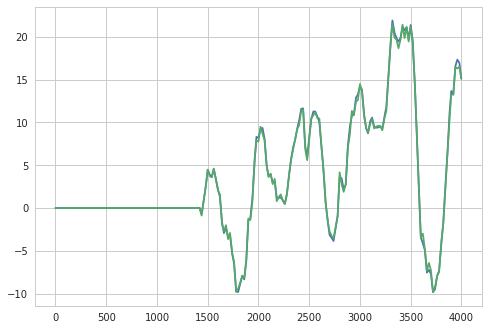

In [18]:
# see how well predictions line up
d = assim_data[0]
Vpred = filter_stimulus(stim, rfparams, upsample)

#Y, S = matmodel.predict(matstate, mparams, I, model_dt, upsample=upsample, stochastic=True)
plt.plot(d["V"][:4000])
plt.plot(Vpred[:4000])

(0, 10000)

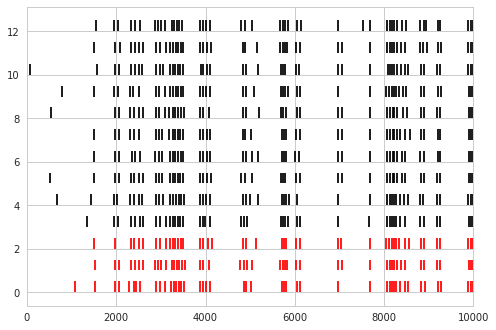

In [19]:
for i, d in enumerate(data):
    plt.vlines(d["spike_t"], i, i + 0.5, 'r')

for i in range(len(data), len(data) + 10):
    S = predict_spikes(Vpred, mparams, model_dt, upsample=1)
    spk_t = S.nonzero()[0]
    plt.vlines(spk_t, i, i + 0.5)

plt.xlim(0, 10000)